In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKmeans


In [2]:
# Part-A
class KMeans:
    def __init__(self, k=3, init='random', max_iters=100, tol=1e-4, random_state=None):
        self.k = k
        self.init = init  # 'random' or 'k-means++'
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0

    def _initialize_centroids_random(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.k, replace=False)
        return X[indices]

    def _initialize_centroids_plus_plus(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_samples = X.shape[0]
        centroids = []

        first_idx = np.random.randint(0, n_samples)
        centroids.append(X[first_idx])

        for _ in range(1, self.k):
            dist_sq = np.min(np.square(np.linalg.norm(X[:, np.newaxis] - np.array(centroids), axis=2)), axis=1)
            probs = dist_sq / np.sum(dist_sq)
            next_idx = np.random.choice(n_samples, p=probs)
            centroids.append(X[next_idx])

        return np.array(centroids)

    def _assign_clusters(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # shape: (n_samples, k)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        new_centroids = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else np.zeros(X.shape[1])
            for i in range(self.k)
        ])
        return new_centroids

    def _compute_inertia(self, X, labels, centroids):
        distances = np.linalg.norm(X - centroids[labels], axis=1)
        return np.sum(distances ** 2)

    def fit(self, X):
        # Step 1: Initialize centroids
        if self.init == 'random':
            centroids = self._initialize_centroids_random(X)
        elif self.init == 'k-means++':
            centroids = self._initialize_centroids_plus_plus(X)
        else:
            raise ValueError("init must be 'random' or 'k-means++'")

        for i in range(self.max_iters):
            # Step 2: Assign clusters
            labels = self._assign_clusters(X, centroids)

            # Step 3: Update centroids
            new_centroids = self._update_centroids(X, labels)

            # Step 4: Check convergence
            shift = np.linalg.norm(new_centroids - centroids)
            if shift < self.tol:
                break

            centroids = new_centroids

        self.centroids = centroids
        self.labels_ = labels
        self.inertia_ = self._compute_inertia(X, labels, centroids)
        self.n_iter_ = i + 1
        return self

    def predict(self, X):
        return self._assign_clusters(X, self.centroids)

    

In [3]:
# Part - B

def elbow_method(X, k_range, init='k-means++', random_state=None):
    inertias = []

    for k in k_range:
        model = KMeans(k=k, init=init, random_state=random_state)
        model.fit(X)
        inertias.append(model.inertia_)

    return inertias


def silhouette_score(X, labels):
    n = len(X)
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    
    if k == 1:
        return 0  # undefined for single cluster

    sil_scores = np.zeros(n)

    for i in range(n):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == lbl] for lbl in unique_labels if lbl != labels[i]]

        a_i = np.mean(np.linalg.norm(same_cluster - X[i], axis=1)) if len(same_cluster) > 1 else 0

        b_i = np.min([np.mean(np.linalg.norm(cluster - X[i], axis=1)) for cluster in other_clusters])

        sil_scores[i] = (b_i - a_i) / max(a_i, b_i)

    return np.mean(sil_scores)


def silhouette_analysis(X, k_range, init='k-means++', random_state=None):
    scores = []

    for k in k_range:
        model = KMeans(k=k, init=init, random_state=random_state)
        model.fit(X)
        score = silhouette_score(X, model.labels_)
        scores.append(score)

    return scores


In [4]:
data = pd.read_csv('./dataset/Mall_Customers.xls')

In [5]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
data = data.drop(columns=['CustomerID'])

In [12]:
X = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values


Summary Statistics:


,Age,Income,Spending
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


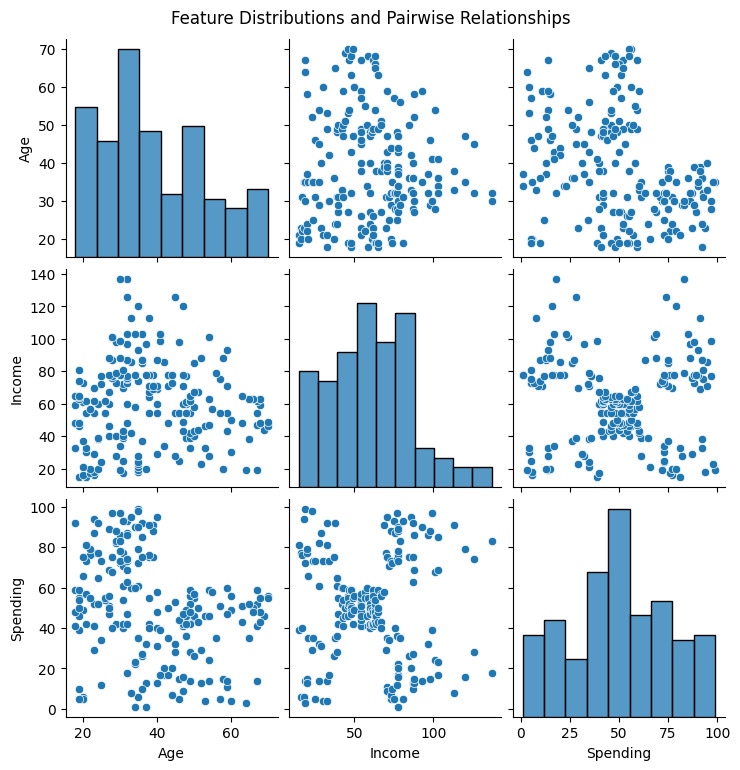

In [13]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nSummary Statistics:")
display(pd.DataFrame(X, columns=['Age','Income','Spending']).describe())

sns.pairplot(pd.DataFrame(X, columns=['Age','Income','Spending']))
plt.suptitle("Feature Distributions and Pairwise Relationships", y=1.02)
plt.show()

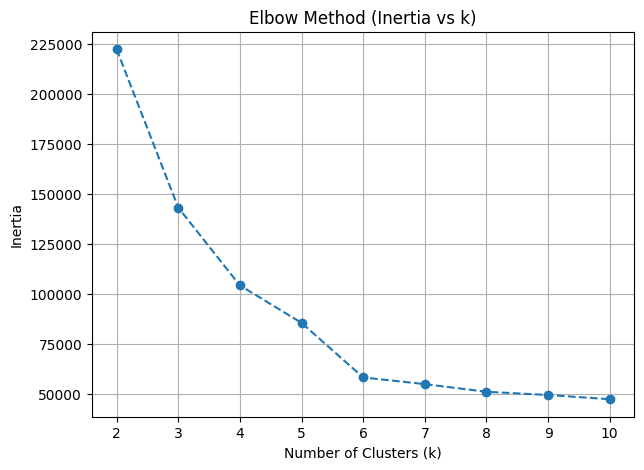

In [14]:
k_values = range(2, 11)

inertias = elbow_method(X, k_values, init='k-means++', random_state=42)

plt.figure(figsize=(7, 5))
plt.plot(k_values, inertias, 'o--')
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

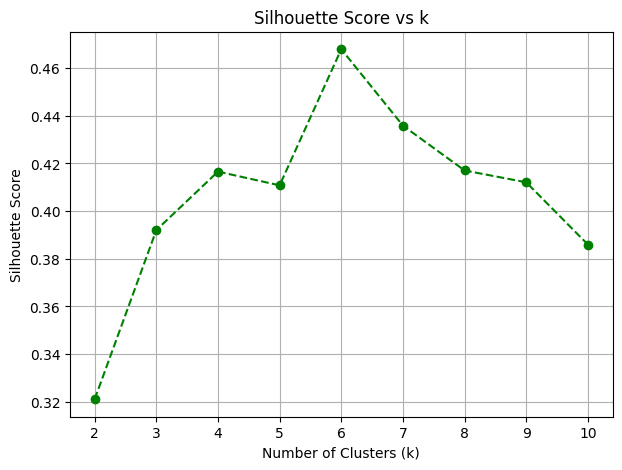

In [15]:
sil_scores = silhouette_analysis(X, k_values, init='k-means++', random_state=42)

plt.figure(figsize=(7, 5))
plt.plot(k_values, sil_scores, 'o--', color='green')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


- highest Silhoutte Score is at K = 6 which is supported by Elbow Method also in the above figures
- This defines K = 6 is best for clustering

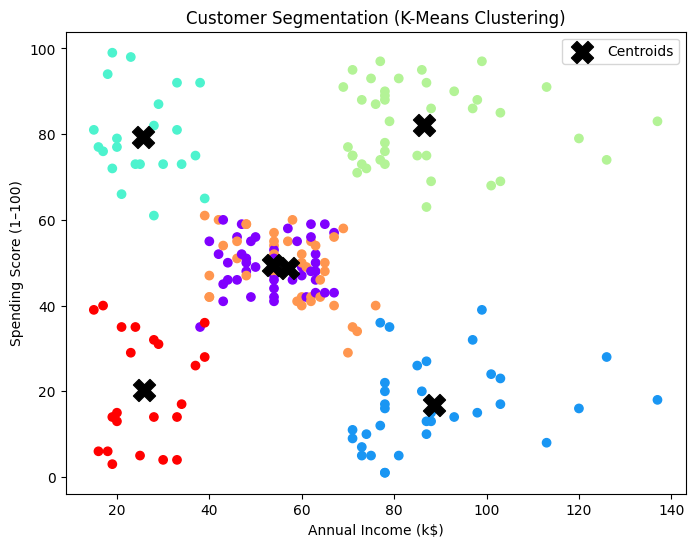

In [16]:
# Part - C
import time
start = time.time()
model = KMeans(k=6, init='k-means++', random_state=42)
model.fit(X)
end = time.time()
custom_time = end - start
data['Cluster'] = model.labels_

plt.figure(figsize=(8,6))
plt.scatter(X[:,1], X[:,2], c=model.labels_, cmap='rainbow')
plt.scatter(model.centroids[:,1], model.centroids[:,2], s=250, c='black', marker='X', label='Centroids')
plt.title("Customer Segmentation (K-Means Clustering)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1–100)")
plt.legend()
plt.show()

In [17]:
start = time.time()
sk_model = SklearnKmeans(n_clusters=6, init='k-means++', random_state=42)
sk_model.fit(X)
end = time.time()
sklearn_time = end - start

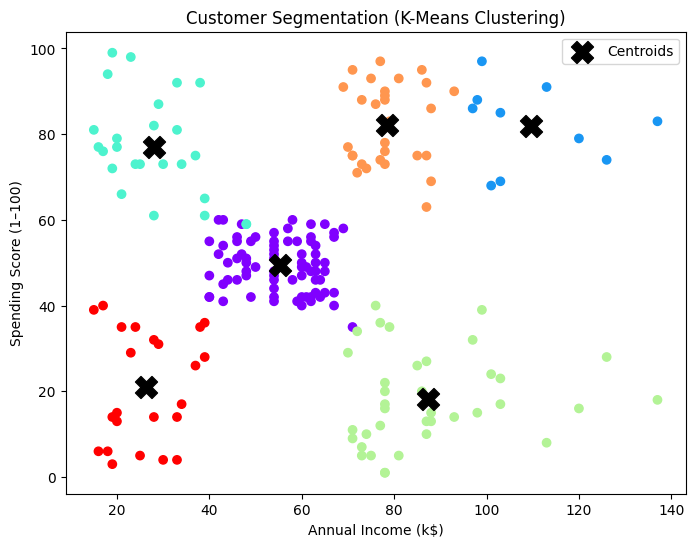

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,1], X[:,2], c=sk_model.labels_, cmap='rainbow')
plt.scatter(sk_model.cluster_centers_[:,1], sk_model.cluster_centers_[:,2],
            s=250, c='black', marker='X', label='Centroids')
plt.title("Customer Segmentation (K-Means Clustering)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1–100)")
plt.legend()
plt.show()


In [19]:
# Part - D

In [21]:
comparison_data = {
    "Model": ["Custom K-Means", "Scikit-learn KMeans"],
    "Iterations": [model.max_iters, sk_model.n_iter_],
    "Inertia": [round(model.inertia_, 2), round(sk_model.inertia_, 2)],
    "Runtime (s)": [round(custom_time, 4), round(sklearn_time, 4)]
}

comparison_df = pd.DataFrame(comparison_data)

centroid_diff = np.linalg.norm(np.sort(model.centroids, axis=0) -
                               np.sort(sk_model.cluster_centers_, axis=0))

print("K-Means Comparison Table")
display(comparison_df)

print(f"\nCentroid Difference (L2 norm): {centroid_diff:.6f}")

print("\nCluster Sizes (Custom K-Means):")
print(data['Cluster'].value_counts().sort_index())


K-Means Comparison Table


,Model,Iterations,Inertia,Runtime (s)
0,Custom K-Means,100,58316.49,0.0035
1,Scikit-learn KMeans,5,68275.94,0.3939



Centroid Difference (L2 norm): 42.807641

Cluster Sizes (Custom K-Means):
Cluster
0    44
1    34
2    22
3    39
4    39
5    22
Name: count, dtype: int64
